In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import ecco_v4_py as ecco
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


### Import ECCO dataset

In [2]:
main = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/').rename({'face': 'tile'})

### Useful quantities

In [3]:
# Density kg/m^3
rhoconst = 1029

# m^3 to Sverdrup
Sv = 10**-6

### Define the section lines 

In [4]:
pt1,pt2 = ecco.get_section_endpoints('Fram Strait')
maskC, maskW, maskS = ecco.get_section_line_masks(pt1,pt2,main)

### Sea ice flux

It is currently unclear what exactly `SIuheff` and `SIvheff` really represents. What are the units of m$^2$ s$^{-1}$ stand for. My guess is that by multiplying `SIuheff` and `SIvheff` with the cell lengths (`dyG` and `dxG`) one can obtain the volume flux of sea ice. Then, another issue is how volume of sea ice is converted to volume of freshwater. This will be relevant when includeing sea ice flux into the freshwater budget (i.e., compare it to freshwater forcing due to melting sea ice).

Sea ice typically has an average salinity, S$_{ice}$, of about **4** (Aagaard and Carmack 1989; it decreases with age). For ease of comparison, we quote the equivalent liquid freshwater volume stored in sea ice throughout. Namely, we multiply ice volume fluxes by 

$$ \left(1 - \frac{S_{ice}}{S_{ref}}\right) \cdot \left(\frac{\rho_{ice}}{\rho_{w}}\right), $$

where $\rho_{ice}$ = **900** kg m$^{−3}$ is the average density of ice, and $\rho_{w}$ = **1003** kg m$^{−3}$ is the density of seawater with salinity $S_{ice}$.

In [5]:
#Sref = 35.0
Sref = 34.9
Sice = 4.0
rho_w = 1003
rho_ice = 900

ice_to_fw = (1-Sice/Sref)*(rho_ice/rho_w)

In [6]:
# Sea ice freshwater fluxes (m^3/s)
SIu_transport = main['SIuheff'] * main['dyG'] * ice_to_fw
SIv_transport = main['SIvheff'] * main['dxG'] * ice_to_fw

In [7]:
# Sea ice freshwater fluxes through strait (m^3/s)
sec_trsp_x = (SIu_transport * maskW).sum(dim=['i_g','j','tile'])
sec_trsp_y = (SIv_transport * maskS).sum(dim=['i','j_g','tile'])

In [8]:
# Sea ice freshwater transport (Sv)
sec_SItrsp = (sec_trsp_x + sec_trsp_y).compute()*Sv

In [12]:
ds = sec_SItrsp.to_dataset(name='SItrsp_FrS')

In [13]:
ds.to_netcdf('/mnt/efs/data/ecco/ecco_section_SItrsp_FrS.nc', format='NETCDF4', 
             encoding={'SItrsp_FrS': {'zlib': True}})

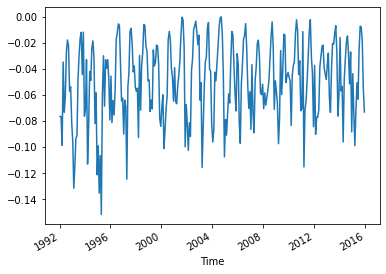

In [9]:
sec_SItrsp.plot()

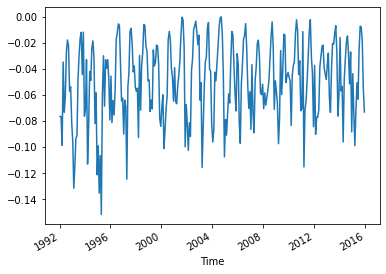

### Compare sea ice flux through Fram Strait with sea ice flux within Nordic Seas

In [15]:
oceFW = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_fw_oceFW.nc')

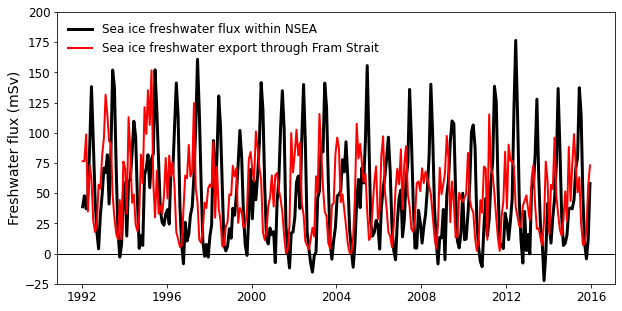

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(oceFW.time, oceFW.sel(region='nsea',term='forcFwSI').fw*1e3, lw=3, color='black',
        label='Sea ice freshwater flux within NSEA')
ax.plot(sec_SItrsp.time, -sec_SItrsp*1e3, lw=2, color='r',linestyle='-',
        label='Sea ice freshwater export through Fram Strait')
ax.set_ylim([-25,200])
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)
ax.legend(loc='upper left',frameon=False,fontsize=12)

plt.show()

#### Flux anomalies

In [17]:
oceFW_anom = oceFW.groupby('time.month') - oceFW.groupby('time.month').mean('time')
SItrsp_anom = sec_SItrsp.groupby('time.month') - sec_SItrsp.groupby('time.month').mean('time')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


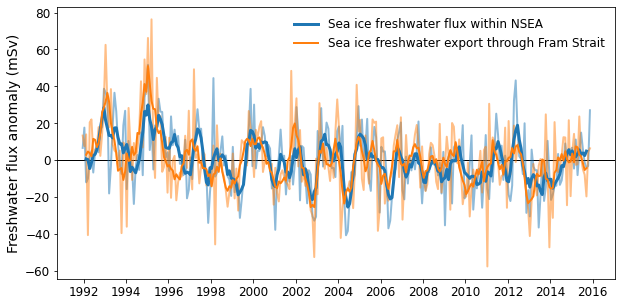

In [19]:
fig, ax = plt.subplots(figsize=(10,5))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(oceFW_anom.time, oceFW_anom.sel(region='nsea',term='forcFwSI').fw*1e3, lw=2,alpha=0.5,label=None)
ax.plot(SItrsp_anom.time, -SItrsp_anom*1e3, lw=2,linestyle='-',alpha=0.5,label=None)
ax.plot(oceFW_anom.time, oceFW_anom.sel(region='nsea',term='forcFwSI').fw.rolling(time=5, center=True).mean()*1e3, 
        lw=3,color='tab:blue',label='Sea ice freshwater flux within NSEA')
ax.plot(SItrsp_anom.time, -SItrsp_anom.rolling(time=5, center=True).mean()*1e3, lw=2,linestyle='-',color='tab:orange',
        label='Sea ice freshwater export through Fram Strait')


#ax.set_ylim([-25,200])
ax.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_ylabel('Freshwater flux anomaly (mSv)',fontsize=14)
ax.legend(loc='upper right',frameon=False,fontsize=12)

plt.savefig('/mnt/efs/figure.png')
plt.savefig('/mnt/efs/figure.eps')
plt.savefig('/mnt/efs/figure.pdf')
plt.show()

In [145]:
df = oceFW_anom.sel(region='nsea',term='forcFwSI').fw.reset_coords(drop=True).to_dataframe(name='SI_flux')
df['FrS_export'] = -SItrsp_anom.reset_coords(drop=True).to_dataframe(name='FrS_export')

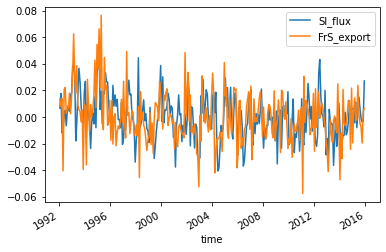

In [146]:
df.plot()

In [147]:
df.corr()

,SI_flux,FrS_export
SI_flux,1.000000,0.422297
FrS_export,0.422297,1.000000


In [126]:
import seaborn as sns

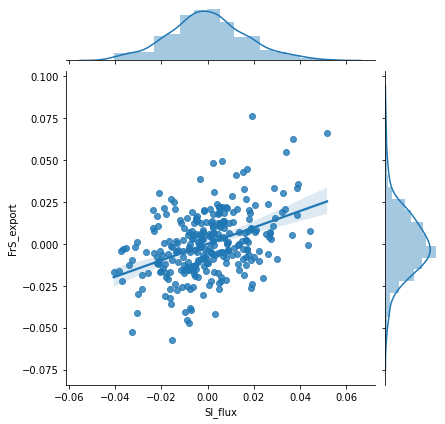

In [127]:
sns.jointplot(x="SI_flux", y="FrS_export", data=df, kind="reg")

In [141]:
# Annual means
df['dt'] = main.reset_coords().dt.sel(time=slice('1992-02-01','2015-11-30')).to_dataframe().dt
df_sub = df.loc[(df.index > '1992-12-31')&(df.index < '2015-01-01')]
df_1yr = df_sub.multiply(df_sub["dt"], axis="index").resample('1A',kind='period').sum().drop(columns=['dt'])

In [143]:
df_1yr.corr()

,SI_flux,FrS_export
SI_flux,1.000000,0.865319
FrS_export,0.865319,1.000000


In [149]:
from scipy import stats

In [155]:
stats.pearsonr(df_1yr.SI_flux,df_1yr.FrS_export)

(0.8653188833274439, 2.0091453157633963e-07)

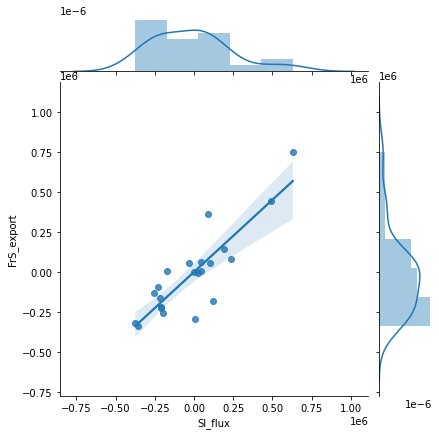

In [148]:
sns.jointplot(x="SI_flux", y="FrS_export", data=df_1yr, kind="reg")

In [109]:
oceFW_int = (oceFW_anom.isel(time=slice(1, -1)).fw*main.isel(time=slice(1, -1)).dt).cumsum(dim='time')
SItrsp_int = (SItrsp_anom.isel(time=slice(1, -1))*main.isel(time=slice(1, -1)).dt).cumsum(dim='time')


oceFW_int_anom = oceFW_int - oceFW_int.mean('time')
SItrsp_int_anom = SItrsp_int - SItrsp_int.mean('time')

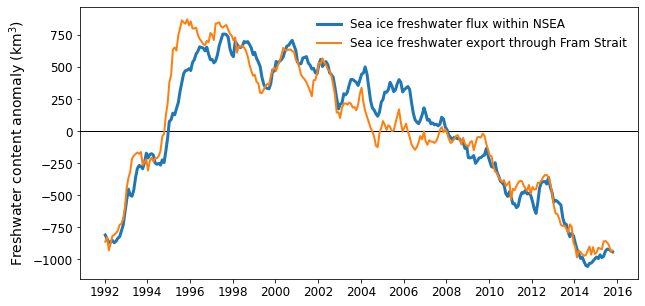

In [113]:
fig, ax = plt.subplots(figsize=(10,5))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(oceFW_int_anom.time, oceFW_int_anom.sel(region='nsea',term='forcFwSI')*1e-3, lw=3,
        label='Sea ice freshwater flux within NSEA')
ax.plot(SItrsp_int_anom.time, -SItrsp_int_anom*1e-3, lw=2, linestyle='-',
        label='Sea ice freshwater export through Fram Strait')
#ax.set_ylim([-25,200])
ax.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_ylabel('Freshwater content anomaly (km$^3$)',fontsize=14)
ax.legend(loc='upper right',frameon=False,fontsize=12)

plt.show()